In [3]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [4]:
engine = create_engine('postgres:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

/home/ben/.environments/stats/lib/python3.8/site-packages/sqlalchemy/dialects/postgresql/base.py:3470: SAWarning: Predicate of partial index files_size ignored during reflection
  util.warn(


In [5]:
start_date = '2020-01-01'
start_time = '2020-01-01 00:00:00'
end_date = '2020-12-31'
end_time = '2021-01-01 00:00:00'

In [6]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_in_period
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads_in_period
0,16184523


In [32]:
pd.read_sql(f"""
    SELECT AVG(downloads) AS daily_avg_downloads
    FROM (
        SELECT COUNT(*) AS downloads
        FROM downloads
        WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY accessed_at::date
    ) downloads_BY_DAY
""", conn)

,daily_avg_downloads
0,44220.008197


In [7]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_to_date
    FROM downloads
    WHERE accessed_at < '{end_time}'
""", conn)

,downloads_to_date
0,21920948


In [8]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_page_hits
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_page_hits
0,2121207


In [9]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_json_downloads
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_json_downloads
0,51149


In [10]:
pd.read_sql(f"""
    SELECT COUNT(*) AS web_page_hits
    FROM web_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,web_page_hits
0,2002602


In [12]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2020-01-01,1079669
1,2020-02-01,985288
2,2020-03-01,1300742
3,2020-04-01,1239451
4,2020-05-01,1271968
5,2020-06-01,1170659
6,2020-07-01,1102139
7,2020-08-01,1737186
8,2020-09-01,1653471
9,2020-10-01,1850781


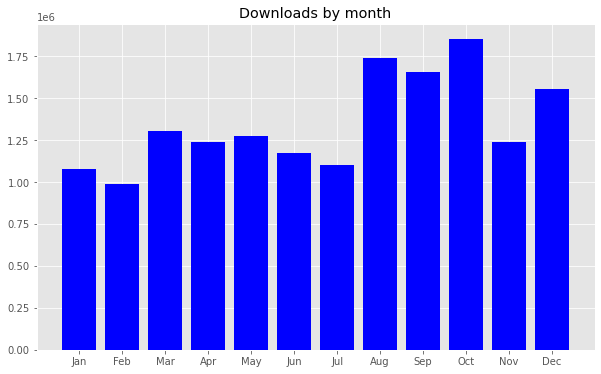

In [15]:
plt.rcParams["figure.figsize"] = (10, 6)

downloads = {
    'Jan': downloads_by_month.c[0],
    'Feb': downloads_by_month.c[1],
    'Mar': downloads_by_month.c[2],
    'Apr': downloads_by_month.c[3],
    'May': downloads_by_month.c[4],
    'Jun': downloads_by_month.c[5],
    'Jul': downloads_by_month.c[6],
    'Aug': downloads_by_month.c[7],
    'Sep': downloads_by_month.c[8],
    'Oct': downloads_by_month.c[9],
    'Nov': downloads_by_month.c[10],
    'Dec': downloads_by_month.c[11],
}

colors = ['blue'] * 12
plt.bar(range(len(downloads)), downloads.values(), color=colors)
plt.title('Downloads by month')
plt.xticks(range(len(downloads)), list(downloads.keys()))

plt.savefig('downloads-by-month.png')

plt.show()

In [16]:
df = pd.read_sql(f"""
    SELECT COUNT(*) AS searches_in_period
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
""", conn)

searches = df.values[0][0]
searches

141009039

In [17]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,98291 days 16:37:23.059288


In [18]:
pd.read_sql(f"""
    select sum(filesize)
    from downloads d
    join files f using (filename)
    where accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,sum
0,52452160990233


In [39]:
top_30_downloads = pd.read_sql(f"""
    select b.package, count(*) c
    from downloads d
    join files f on f.filename = d.filename
    join builds b on b.build_id = f.build_id
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by b.package
    order by c desc
    limit 30;
""", conn)

top_30_downloads

,package,c
0,numpy,1004056
1,dogpile-cache,389999
2,webrtcvad-wheels,356793
3,pyyaml,351503
4,sentry-sdk,350834
5,semantic-version,314402
6,cffi,301478
7,markdown,284277
8,flask-login,266479
9,pycparser,259366


In [41]:
print("<ol>")
for i, row in top_30_downloads.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (1,004,056)</li>
<li><strong><a href='https://www.piwheels.org/project/dogpile-cache'>dogpile-cache</a></strong> (389,999)</li>
<li><strong><a href='https://www.piwheels.org/project/webrtcvad-wheels'>webrtcvad-wheels</a></strong> (356,793)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (351,503)</li>
<li><strong><a href='https://www.piwheels.org/project/sentry-sdk'>sentry-sdk</a></strong> (350,834)</li>
<li><strong><a href='https://www.piwheels.org/project/semantic-version'>semantic-version</a></strong> (314,402)</li>
<li><strong><a href='https://www.piwheels.org/project/cffi'>cffi</a></strong> (301,478)</li>
<li><strong><a href='https://www.piwheels.org/project/markdown'>markdown</a></strong> (284,277)</li>
<li><strong><a href='https://www.piwheels.org/project/flask-login'>flask-login</a></strong> (266,479)</li>
<li><strong><a href='https://www.piwheels.org/proj

In [35]:
top_10_searches = pd.read_sql(f"""
    select package, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_searches

,package,c
0,pip,15765332
1,wheel,6921171
2,setuptools,4534167
3,youtube-dl,3619434
4,pyrogram,2473570
5,requests,2181233
6,numpy,1901582
7,certifi,1827707
8,urllib3,1693529
9,six,1592086


In [36]:
print("<ol>")
for pkg, c in top_10_searches.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (15,765,332)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (6,921,171)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (4,534,167)</li>
<li><strong><a href='https://www.piwheels.org/project/youtube-dl'>youtube-dl</a></strong> (3,619,434)</li>
<li><strong><a href='https://www.piwheels.org/project/pyrogram'>pyrogram</a></strong> (2,473,570)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (2,181,233)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (1,901,582)</li>
<li><strong><a href='https://www.piwheels.org/project/certifi'>certifi</a></strong> (1,827,707)</li>
<li><strong><a href='https://www.piwheels.org/project/urllib3'>urllib3</a></strong> (1,693,529)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (1,592,08

In [37]:
top_10_project_pages = pd.read_sql(f"""
    select package, count(*) c
    from project_page_hits
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_pages

,package,c
0,opencv-python,8572
1,opencv-contrib-python,4727
2,numpy,4627
3,scipy,3973
4,tensorflow,3892
5,pillow,1858
6,pip,1792
7,grpcio,1594
8,opencv-python-headless,1263
9,pandas,1187


In [38]:
print("<ol>")
for pkg, c in top_10_project_pages.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (8,572)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (4,727)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (4,627)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (3,973)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (3,892)</li>
<li><strong><a href='https://www.piwheels.org/project/pillow'>pillow</a></strong> (1,858)</li>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (1,792)</li>
<li><strong><a href='https://www.piwheels.org/project/grpcio'>grpcio</a></strong> (1,594)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-python-headless'>opencv-python-headless</a></strong> (1,263)</li>
<li><strong><a href='https://www.piwheels.org/project/pandas'>pand

In [42]:
os_usage = pd.read_sql(f"""
    select os_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by os_name
    order by c desc
""", conn)

os_usage

,os_name,c
0,Linux,140815096
1,Windows,113763
2,Darwin,78550
3,FreeBSD,1165
4,None,422
5,Ibnu Rifqi,21
6,CYGWIN_NT-10.0-18363,10
7,OpenBSD,5
8,MINGW64_NT-10.0-18363,3
9,L,2


In [43]:
os_usage.values[0][1] / searches

0.9986246059020373

In [44]:
distro_usage = pd.read_sql(f"""
    select distro_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    group by distro_name
    order by c desc
    limit 5
""", conn)

distro_usage

,distro_name,c
0,Raspbian GNU/Linux,132440012
1,Debian GNU/Linux,6483610
2,Ubuntu,1229348
3,Red Hat Enterprise Linux Server,275270
4,Alpine Linux,129498


In [45]:
distro_versions = pd.read_sql(f"""
    select distro_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version in ('8', '9', '10')
    group by distro_version
    order by c desc
""", conn)

distro_versions

,distro_version,c
0,10,105691933
1,9,32726316
2,8,15497


In [46]:
total = sum(distro_versions.c)

for v in distro_versions.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%')

10 76.3%
9 23.6%
8 0.0%


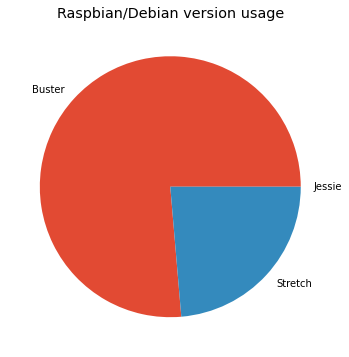

In [47]:
version_names = {'10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(distro_versions.c, labels=[version_names[v] for v in distro_versions.distro_version])
plt.title('Raspbian/Debian version usage')

plt.savefig('debian-usage.png')

plt.show()

In [48]:
arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by arch
    order by c desc
""", conn)

arch

,arch,c
0,armv7l,126976015
1,armv6l,7697603
2,aarch64,2986842
3,x86_64,2949746
4,i686,228012
5,AMD64,113758
6,armv8l,54431
7,amd64,1170
8,ppc64le,611
9,None,422


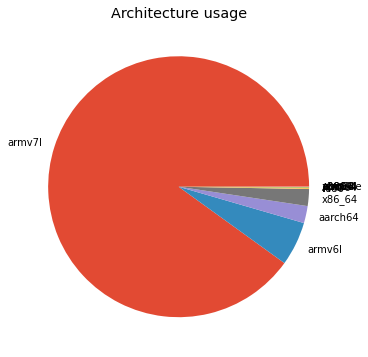

In [49]:
plt.pie(arch.c, labels=arch.arch)
plt.title('Architecture usage')

plt.savefig('arch.png')

plt.show()

In [50]:
arm_arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    group by arch
    order by c desc
""", conn)

total = sum(arm_arch.c)

for v in arm_arch.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

armv7l 92.4%
armv6l 5.6%
aarch64 2.0%


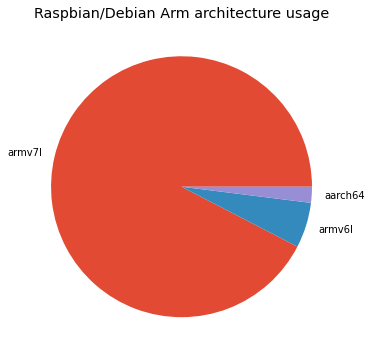

In [51]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('Raspbian/Debian Arm architecture usage')

plt.savefig('debian-arch.png')

plt.show()

In [52]:
py_vers = pd.read_sql(f"""
    select substring(py_version from 1 for 3) pyver, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and py_name = 'CPython'
    group by pyver
    order by c desc
    limit 5
""", conn)

py_vers

,pyver,c
0,3.7,76938781
1,2.7,43907496
2,3.5,10568656
3,3.8,6960455
4,3.6,2115622


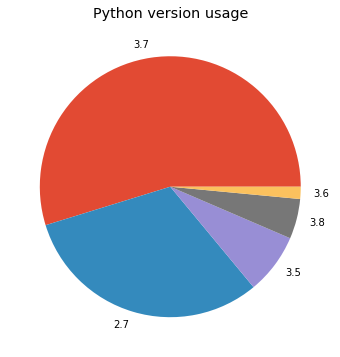

In [53]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('py-vers.png')

plt.show()

In [54]:
total = sum(row[1] for row in py_vers.values)

for ver, c in py_vers.values:
    print(ver, f'{100 * (c / total):.2f}%')

3.7 54.76%
2.7 31.25%
3.5 7.52%
3.8 4.95%
3.6 1.51%


In [55]:
pip_versions = pd.read_sql(f"""
    select installer_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and installer_version is not null
    group by installer_version
    order by c desc
""", conn)

pip_versions[:10]

,installer_version,c
0,18.1,42194370
1,9.0.1,18219576
2,19.3.1,13519046
3,20.0.2,11553138
4,20.1.1,10599592
5,20.2.4,8834934
6,20.2.3,7712525
7,20.2.2,6830430
8,20.2,3116065
9,19.2.3,3097924


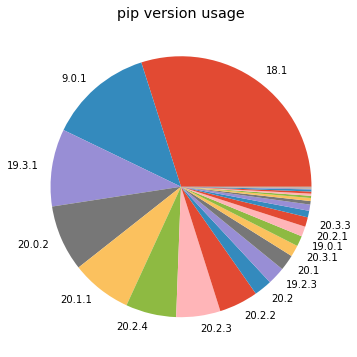

In [56]:
total = sum(v[1] for v in pip_versions.values)
labels = [v[0] if v[1] / total > 0.01 else '' for v in pip_versions.values]

plt.pie(pip_versions.c, labels=labels)
plt.title('pip version usage')

plt.savefig('pip-vers.png')

plt.show()

In [57]:
setuptools_versions = pd.read_sql(f"""
    select setuptools_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and setuptools_version is not null
    group by setuptools_version
    order by c desc
""", conn)

setuptools_versions[:10]

,setuptools_version,c
0,40.8.0,58882722
1,41.5.1,8303561
2,41.2.0,6372365
3,46.1.3,4139548
4,50.3.2,3664654
5,50.3.0,3196434
6,44.1.1,3037389
7,44.0.0,2917250
8,49.2.0,2276389
9,42.0.2,2181558


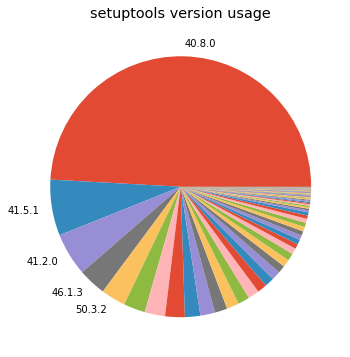

In [58]:
total = sum(v[1] for v in setuptools_versions.values)
labels = [v[0] if v[1] / total > 0.03 else '' for v in setuptools_versions.values]

plt.pie(setuptools_versions.c, labels=labels)
plt.title('setuptools version usage')

plt.savefig('setuptools-vers.png')

plt.show()

In [62]:
downloads_by_hour = pd.read_sql(f"""
    select date_part('hour', accessed_at) h, count(*) c
    from downloads
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by h
    order by h
""", conn)

In [68]:
list(downloads_by_hour['c'])

[511159,
 514747,
 467567,
 440892,
 440012,
 449358,
 487656,
 555893,
 625293,
 684754,
 710860,
 728097,
 759932,
 815418,
 863938,
 893043,
 879065,
 850085,
 849308,
 836928,
 820064,
 752722,
 668981,
 578751]

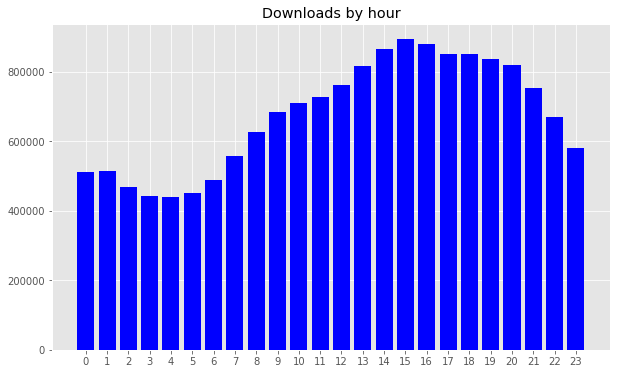

In [75]:
hours = [int(h) for h in downloads_by_hour['h']]

plt.bar(range(len(downloads_by_hour)), list(downloads_by_hour['c']), color=['blue'] * 24)
plt.title('Downloads by hour')
plt.xticks(range(len(downloads_by_hour)), hours)

plt.savefig('downloads-by-hour.png')

plt.show()